# Visualizing Activation Maps for Emotion Detection

In [1]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2


## Load the Pretrained Model

In [2]:

# Load the model
with open('model_a1.json', 'r') as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights('model_weights1.h5')
print("Model loaded successfully.")


Model loaded successfully.


## Preprocess the Image

In [3]:

# Preprocess the image
def preprocess_image(image_path):
    image = load_img(image_path, color_mode="grayscale", target_size=(48, 48))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    image_array = image_array / 255.0  # Normalize
    return image_array


## Generate Activation Maps

In [4]:

# Generate activation maps
def generate_activation_map(model, image_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_array)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute weighted combination of feature maps
    activation_map = tf.reduce_sum(weights * conv_outputs[0], axis=-1).numpy()

    # Normalize activation map
    activation_map = np.maximum(activation_map, 0)
    activation_map /= np.max(activation_map)
    return activation_map


## Overlay Activation Map on the Original Image

In [5]:

# Overlay activation map on the original image
def overlay_activation_map(image_path, activation_map):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (48, 48))

    # Convert to RGB if grayscale
    if len(image.shape) == 2 or image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Resize the activation map to match the image size
    activation_map_resized = cv2.resize(activation_map, (image.shape[1], image.shape[0]))

    heatmap = cv2.applyColorMap(np.uint8(255 * activation_map_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
    return overlay


## Visualize the Results

Image shape: (1, 48, 48, 1)
Activation map shape: (12, 12)


C:\Users\arvin\AppData\Local\Temp\ipykernel_15912\3496294976.py:22: RuntimeWarning: invalid value encountered in true_divide
  activation_map /= np.max(activation_map)


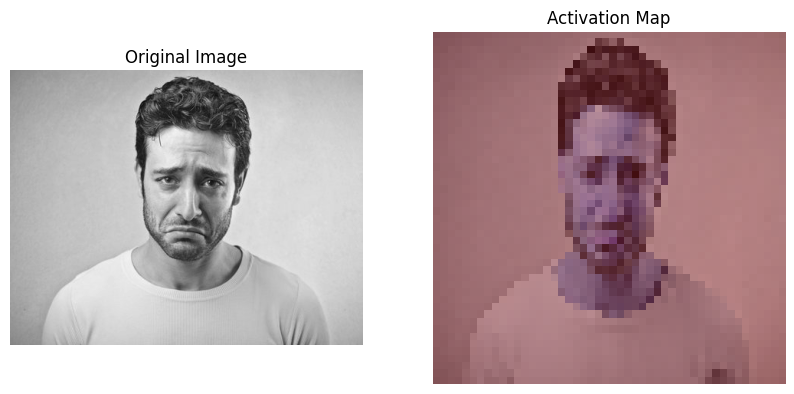

In [7]:

# Test the pipeline
test_image_path = 'sadface.jpg'  # Replace with your test image path

if not test_image_path:
    raise ValueError("c:/Users/arvin/Documents/Emotion_detection/sadface.jpg")

# Preprocess the image
input_image = preprocess_image(test_image_path)

# Generate activation map for a specific layer
target_layer = 'conv2d_2'  # Replace with the layer you want to analyze
activation_map = generate_activation_map(model, input_image, target_layer)

# Check dimensions for debugging
print("Image shape:", input_image.shape)
print("Activation map shape:", activation_map.shape)

# Overlay the activation map
overlay_image = overlay_activation_map(test_image_path, activation_map)

# Display the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Activation Map")
plt.imshow(overlay_image)
plt.axis('off')

plt.show()
